In [1]:
import numpy as np
import random
#import kali.csvLC
#import kali.carma
import matplotlib as mpl
import matplotlib.pyplot as plt
#import imp
#imp.reload(mpl); imp.reload(plt);
%matplotlib inline

In [2]:
import richardsplot as rplot

In [13]:
def discreteacf(t,y,binning = False, Nbins = 100):
    """
    computes a binned ACF for irregular lightcurves or time series
    t = time array (even grid is not necessary)
    y = fluxes or magnitudes
    """
    
    #t = data[0,:]
    #y = data[1,:]
    avg = np.mean(y)
    sigma = np.std(y)
    indexP = 0
    N = len(t)
    acf = np.array([])
    P = np.zeros(shape = [2, (N-1)*N])
    for n in range(0, len(t)-1):
        #speed up this inner loop
        for k in range(0,len(t)-n):
            indexP = indexP+1
            product = (y[n]-avg)*(y[n+k]-avg)
            dt = t[n+k]-t[n]
            P[:,indexP] = np.array([product,dt])
            
    sortedP = np.sort(P[:,P[1,:]!= 0], axis = 0)
    
    if binning == True:
        print("binning")
        #replace histogram function with unitary function
        counts = plt.hist(wfd[0,:],bins = 300)
        bin_edges = counts[1]
        divide = np.array(counts[0])
        # condition below fixes divide by zero, numerator will still be zero for bins with zero observations
        divide[divide ==0] = 1
        for i in range(0, len(bin_edges)-1):
            dt = sortedP[1, :]
            mask = ( (dt < bin_edges[i+1]) &  (dt > bin_edges[i]))
            Sum = np.sum(sortedP[0, mask])
            acf = np.append(acf, Sum/divide[i])
        ACF = acf  
    else:
        ACF = P
    return ACF, bin_edges , P    

In [14]:
#import your data here
ddf = np.loadtxt('/Users/Jackster/Dropbox/ddfCadenceLC_dho_real.txt')
wfd = np.loadtxt('/Users/Jackster/Dropbox/wfdCadenceLC_dho_real.txt')

binning
binning


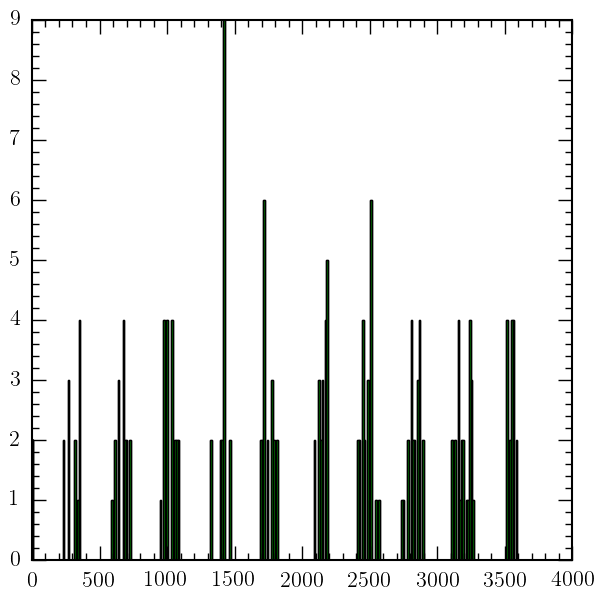

In [15]:
ACFwfd, bin_edgeswfd, pWFD = discreteacf(wfd[0,:],wfd[1,:],binning = True)
ACFddf, bin_edgesddf, pDDF = discreteacf(ddf[0,:],ddf[1,:],binning = True)


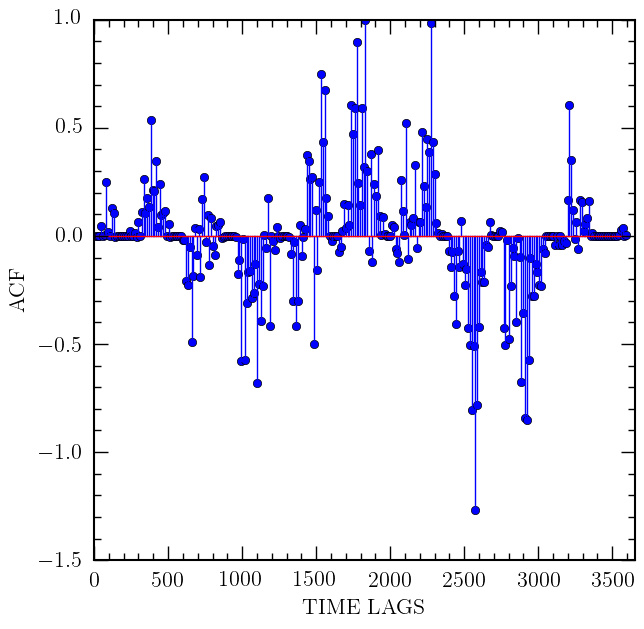

In [16]:
plt.stem(bin_edgeswfd[1:],ACFwfd/ACFwfd.max(), color = "orange", alpha = 0.5)
#plt.stem(bin_edgesddf[1:],ACFddf/ACFddf.max(), color = 'darkblue', alpha = 0.5)
plt.xlim(0,365*10)
plt.ylabel('ACF')
plt.xlabel('TIME LAGS')

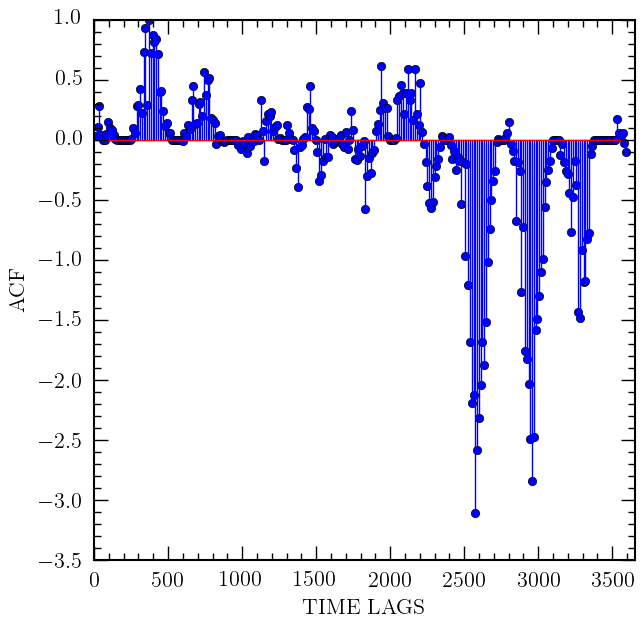

In [17]:
plt.stem(bin_edgesddf[1:],ACFddf/ACFddf.max(), color = 'darkblue', alpha = 0.5)
plt.xlim(0,365*10)
plt.ylabel('ACF')
plt.xlabel('TIME LAGS')